In [1]:
from save_random_pickles import random_pickles

from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import random

MODEL_PATH = "yamnet.pth"
EPOCH = 10
BATCH_SIZE = 32
THRESHOLD = 0.5

device = torch.device('mps')

# Model

In [2]:
# YAMNet PyTorch Implementation
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class DepthwiseConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseConvBlock, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding, 
                                   groups=in_channels, bias=False)
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class YAMNet(nn.Module):
    def __init__(self, num_classes=521):
        super(YAMNet, self).__init__()
        
        # Initial convolution
        self.conv1 = ConvBlock(1, 32, kernel_size=3, stride=1, padding=1)
        
        # Depthwise separable convolutions with different configurations
        self.layers = nn.Sequential(
            # Block 1
            DepthwiseConvBlock(32, 64, kernel_size=3, stride=1, padding=1),
            DepthwiseConvBlock(64, 64, kernel_size=3, stride=2, padding=1),
            
            # Block 2
            DepthwiseConvBlock(64, 128, kernel_size=3, stride=1, padding=1),
            DepthwiseConvBlock(128, 128, kernel_size=3, stride=2, padding=1),
            
            # Block 3
            DepthwiseConvBlock(128, 128, kernel_size=3, stride=1, padding=1),
            DepthwiseConvBlock(128, 128, kernel_size=3, stride=2, padding=1),
            
            # Block 4
            DepthwiseConvBlock(128, 256, kernel_size=3, stride=1, padding=1),
            DepthwiseConvBlock(256, 256, kernel_size=3, stride=2, padding=1),
            
            # Block 5
            DepthwiseConvBlock(256, 256, kernel_size=3, stride=1, padding=1),
            DepthwiseConvBlock(256, 256, kernel_size=3, stride=2, padding=1),
            
            # Block 6
            DepthwiseConvBlock(256, 512, kernel_size=3, stride=1, padding=1),
            DepthwiseConvBlock(512, 512, kernel_size=3, stride=2, padding=1),
        )
        
        # Global average pooling
        self.gap = nn.AdaptiveAvgPool1d(1)
        
        # Classification head
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layers(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [3]:
# Initialize YAMNet model with pre-trained weights
yamnet_model = YAMNet(num_classes=1).to(device=device)

# Load pre-trained weights
saved_weights = torch.load(MODEL_PATH)
print("Loaded weights keys:", list(saved_weights.keys())[:10])

# Try to load weights into the model
try:
    yamnet_model.load_state_dict(saved_weights, strict=False)
    print("✓ Weights loaded successfully (with strict=False)")
except Exception as e:
    print(f"Weight loading error: {e}")
    
    # Alternative: try to adapt weights
    model_dict = yamnet_model.state_dict()
    filtered_weights = {k: v for k, v in saved_weights.items() if k in model_dict and v.size() == model_dict[k].size()}
    model_dict.update(filtered_weights)
    yamnet_model.load_state_dict(model_dict)
    print(f"✓ Partially loaded {len(filtered_weights)} weight tensors")

# Set to evaluation mode
yamnet_model.eval()

Loaded weights keys: ['layer1.fused.conv.weight', 'layer1.fused.bn.weight', 'layer1.fused.bn.bias', 'layer1.fused.bn.running_mean', 'layer1.fused.bn.running_var', 'layer1.fused.bn.num_batches_tracked', 'layer2.depthwise_conv.conv.weight', 'layer2.depthwise_conv.bn.weight', 'layer2.depthwise_conv.bn.bias', 'layer2.depthwise_conv.bn.running_mean']
✓ Weights loaded successfully (with strict=False)


YAMNet(
  (conv1): ConvBlock(
    (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (layers): Sequential(
    (0): DepthwiseConvBlock(
      (depthwise): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), groups=32, bias=False)
      (pointwise): Conv1d(32, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): DepthwiseConvBlock(
      (depthwise): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,), groups=64, bias=False)
      (pointwise): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): DepthwiseConvBlock(
      (depthwise): Conv1d(64, 6

In [4]:
# Test the model with a dummy input
test_input = torch.randn(1, 1, 16000).to(device)  # (batch_size, channels, samples)
with torch.no_grad():
    output = yamnet_model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"✓ Model inference successful!")

Input shape: torch.Size([1, 1, 16000])
Output shape: torch.Size([1, 1])
✓ Model inference successful!


# Dataset load

In [5]:
sneeze, not_sneeze = random_pickles()
dataset_dict = dict(sneeze=sneeze, not_sneeze=not_sneeze)

Processing 968 not-sneeze samples:   0%|          | 0/968 [00:00<?, ?it/s]/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolid

In [6]:
# ...existing code...
def normalization_minmax(data, feature_range=(0.0, 1.0), default_label=None):
    a, b = feature_range
    normalized_data = []
    for item in data:
        # item이 (audio, label)인지 검사
        if isinstance(item, (list, tuple)) and len(item) >= 2:
            audio, label = item[0], item[1]
        else:
            audio = item
            if default_label is None:
                raise ValueError("Item has no label and no default_label provided")
            label = default_label

        if not isinstance(audio, torch.Tensor):
            audio = torch.tensor(audio, dtype=torch.float32)
        audio = audio.float()

        amin = torch.min(audio)
        amax = torch.max(audio)
        if amax > amin:
            norm = (audio - amin) / (amax - amin)
            norm = norm * (b - a) + a
        else:
            norm = torch.full_like(audio, (a + b) / 2.0)

        normalized_data.append((norm, label))
    return normalized_data

for key in list(dataset_dict.keys()):
    default = 1 if key.lower().startswith('sneeze') else 0
    dataset_dict[key] = normalization_minmax(dataset_dict[key], feature_range=(0.0, 1.0), default_label=default)
    print(f"✓ {key} dataset min-max normalized to [0, 1] (default_label={default})")

✓ sneeze dataset min-max normalized to [0, 1] (default_label=1)
✓ not_sneeze dataset min-max normalized to [0, 1] (default_label=0)


In [7]:
train_dataset, test_dataset = {}, {}
for key in dataset_dict:
    data = dataset_dict[key]
    random.shuffle(data)
    split_idx = int(0.8 * len(data))
    train_dataset[key] = data[:split_idx]
    test_dataset[key] = data[split_idx:]

print(f"Train/Test split ratios:")
for key in dataset_dict:
    train_len = len(train_dataset[key])
    test_len = len(test_dataset[key])
    total_len = len(dataset_dict[key])
    print(f"  {key}: {train_len}/{test_len} ({train_len/total_len:.2%}/{test_len/total_len:.2%})")

Train/Test split ratios:
  sneeze: 774/194 (79.96%/20.04%)
  not_sneeze: 774/194 (79.96%/20.04%)


In [8]:
class SneezeNotSneezeDataset(Dataset):
    def __init__(self, sneeze_data, not_sneeze_data, batch_size=None,transform=None):
        self.data = sneeze_data + not_sneeze_data
        self.labels = [1] * len(sneeze_data) + [0] * len(not_sneeze_data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        
        if isinstance(sample, (list, tuple)) and len(sample) >= 2:
            audio, sample_label = sample[0], sample[1]
            label = sample_label
        else:
            audio = sample
            label = self.labels[idx]

        if not isinstance(audio, torch.Tensor):
            audio = torch.tensor(audio, dtype=torch.float32)

        if audio.dim() == 1:
            audio = audio.unsqueeze(0)

        if self.transform:
            audio = self.transform(audio)

        return audio, label

class DataloaderWrapper:
    def __init__(self, dataset, batch_size=32, shuffle=True):
        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = DataloaderWrapper(SneezeNotSneezeDataset(train_dataset['sneeze'], train_dataset['not_sneeze'], batch_size=BATCH_SIZE))
test_dataloader = DataloaderWrapper(SneezeNotSneezeDataset(test_dataset['sneeze'], test_dataset['not_sneeze'], batch_size=BATCH_SIZE))

# Model

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    yamnet_model.parameters(), 
    lr=0.001, 
    # weight_decay=0.001,
)

In [10]:
print(device)
print(next(yamnet_model.parameters()).device)

mps
mps:0


In [11]:
for inputs, labels in train_dataloader.dataloader:
    print(type(inputs), getattr(inputs, 'shape', None))
    print(type(labels), getattr(labels, 'shape', None))
    break

<class 'torch.Tensor'> torch.Size([32, 1, 32000])
<class 'torch.Tensor'> torch.Size([32])


In [12]:
saved = torch.load(MODEL_PATH, map_location='cpu')
print(len(saved), list(saved.keys())[:20])
for k in list(saved.keys())[:10]:
    print(k, saved[k].size())

164 ['layer1.fused.conv.weight', 'layer1.fused.bn.weight', 'layer1.fused.bn.bias', 'layer1.fused.bn.running_mean', 'layer1.fused.bn.running_var', 'layer1.fused.bn.num_batches_tracked', 'layer2.depthwise_conv.conv.weight', 'layer2.depthwise_conv.bn.weight', 'layer2.depthwise_conv.bn.bias', 'layer2.depthwise_conv.bn.running_mean', 'layer2.depthwise_conv.bn.running_var', 'layer2.depthwise_conv.bn.num_batches_tracked', 'layer2.pointwise_conv.conv.weight', 'layer2.pointwise_conv.bn.weight', 'layer2.pointwise_conv.bn.bias', 'layer2.pointwise_conv.bn.running_mean', 'layer2.pointwise_conv.bn.running_var', 'layer2.pointwise_conv.bn.num_batches_tracked', 'layer3.depthwise_conv.conv.weight', 'layer3.depthwise_conv.bn.weight']
layer1.fused.conv.weight torch.Size([32, 1, 3, 3])
layer1.fused.bn.weight torch.Size([32])
layer1.fused.bn.bias torch.Size([32])
layer1.fused.bn.running_mean torch.Size([32])
layer1.fused.bn.running_var torch.Size([32])
layer1.fused.bn.num_batches_tracked torch.Size([])
laye

In [13]:
train_loss, val_loss = [], []
train_acc, val_acc = [], []
for epoch in range(EPOCH):
    previous_loss = None
    yamnet_model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_dataloader.dataloader, desc=f"Epoch {epoch+1} Train", leave=False, total=len(train_dataloader.dataloader), position=0):
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = yamnet_model(inputs)
        probs = outputs.squeeze()
        preds = (probs >= THRESHOLD).float()

        loss = criterion(probs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_dataloader.dataloader.dataset)
    epoch_acc = running_corrects / len(train_dataloader.dataloader.dataset)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    print(f"Epoch {epoch+1}/{EPOCH}, Training Loss: {epoch_loss:.8f}, Training Acc: {epoch_acc:.4f}")

    yamnet_model.eval()
    running_val_loss = 0.0
    running_val_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader.dataloader, desc=f"Epoch {epoch+1} Val", leave=False, total=len(test_dataloader.dataloader), position=0):
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = yamnet_model(inputs)
            probs = outputs.squeeze()
            preds = (probs >= THRESHOLD).float()

            loss = criterion(probs.squeeze(), labels)
            running_val_loss += loss.item() * inputs.size(0)
            running_val_corrects += (preds == labels).sum().item()

        epoch_val_loss = running_val_loss / len(test_dataloader.dataloader.dataset)
        epoch_val_acc = running_val_corrects / len(test_dataloader.dataloader.dataset)
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)
    print(f"Epoch {epoch+1}/{EPOCH}, Validation Loss: {epoch_val_loss:.8f}, Validation Acc: {epoch_val_acc:.4f}")

    model_timestampe = f"epoch{epoch+1}_val{epoch_val_loss:.8f}"
    if previous_loss is None or epoch_val_loss > previous_loss:
        torch.save(yamnet_model.state_dict(), f"./fine_tuned_model/yamnet_finetuned_{model_timestampe}.pth")
        print(f"  ✓ Model saved as yamnet_{model_timestampe}.pth")
    print("====================================")

Epoch 1/10, Training Loss: 0.63102478, Training Acc: 0.7429


Epoch 1/10, Validation Loss: 0.63573513, Validation Acc: 0.7758
  ✓ Model saved as yamnet_epoch1_val0.63573513.pth


Epoch 2/10, Training Loss: 0.60476888, Training Acc: 0.7926


Epoch 2/10, Validation Loss: 0.60633522, Validation Acc: 0.7474
  ✓ Model saved as yamnet_epoch2_val0.60633522.pth


Epoch 3/10, Training Loss: 0.59304889, Training Acc: 0.8107


Epoch 3/10, Validation Loss: 0.57909735, Validation Acc: 0.8351
  ✓ Model saved as yamnet_epoch3_val0.57909735.pth


Epoch 4/10, Training Loss: 0.58946928, Training Acc: 0.8211


Epoch 4/10, Validation Loss: 0.57498505, Validation Acc: 0.8557
  ✓ Model saved as yamnet_epoch4_val0.57498505.pth


Epoch 5/10, Training Loss: 0.58840215, Training Acc: 0.8198


Epoch 5/10, Validation Loss: 0.57399291, Validation Acc: 0.8351
  ✓ Model saved as yamnet_epoch5_val0.57399291.pth


Epoch 6/10, Training Loss: 0.59161687, Training Acc: 0.8036


Epoch 6/10, Validation Loss: 0.57450601, Validation Acc: 0.8505
  ✓ Model saved as yamnet_epoch6_val0.57450601.pth


Epoch 7/10, Training Loss: 0.58280068, Training Acc: 0.8379


Epoch 7/10, Validation Loss: 0.58562098, Validation Acc: 0.8351
  ✓ Model saved as yamnet_epoch7_val0.58562098.pth


Epoch 8/10, Training Loss: 0.58342638, Training Acc: 0.8372


Epoch 8/10, Validation Loss: 0.56614243, Validation Acc: 0.8711
  ✓ Model saved as yamnet_epoch8_val0.56614243.pth


Epoch 9/10, Training Loss: 0.57695492, Training Acc: 0.8475


Epoch 9/10, Validation Loss: 0.56342524, Validation Acc: 0.8892
  ✓ Model saved as yamnet_epoch9_val0.56342524.pth


Epoch 10/10, Training Loss: 0.58445313, Training Acc: 0.8262


Epoch 10/10, Validation Loss: 0.58175173, Validation Acc: 0.8376
  ✓ Model saved as yamnet_epoch10_val0.58175173.pth


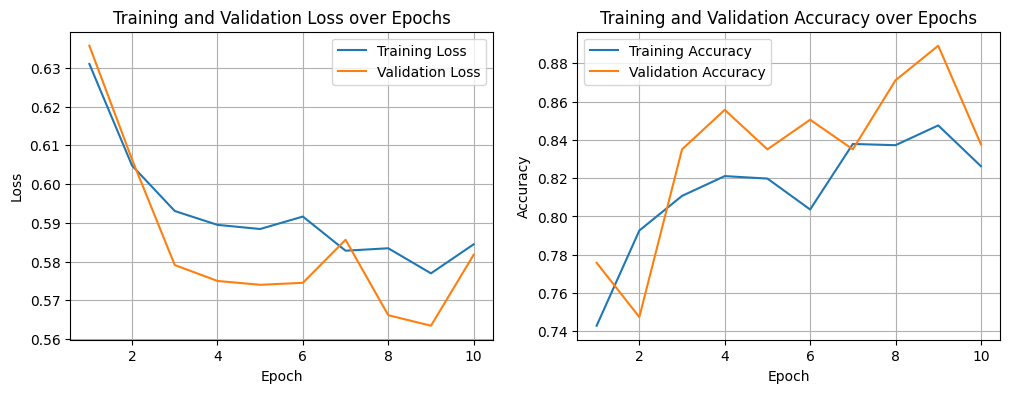

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCH + 1), train_loss, label='Training Loss')
plt.plot(range(1, EPOCH + 1), val_loss, label='Validation Loss')
# plt.ylim(top=max(val_loss), bottom=0.0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCH + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, EPOCH + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid()

plt.show()

/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_52890/3340296596.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


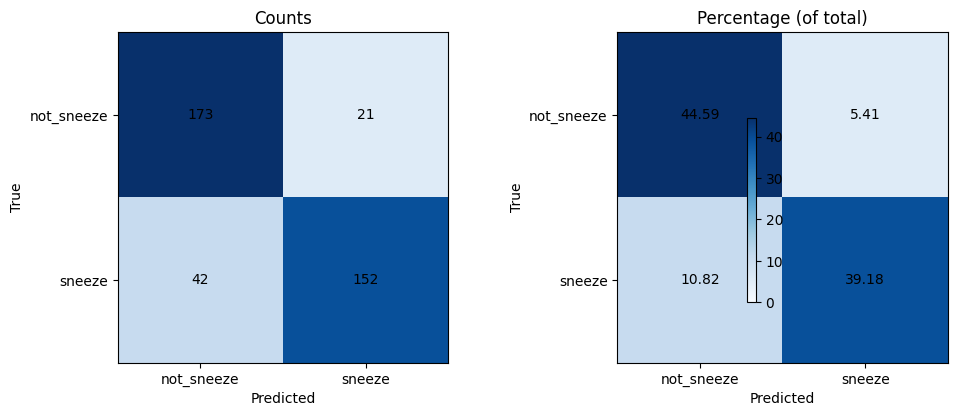

Confusion matrix (counts):
 [[173  21]
 [ 42 152]]
Confusion matrix (percentage of total samples):
 [[44.59  5.41]
 [10.82 39.18]]


In [15]:
yamnet_model.eval()
y_trues, y_preds = [], []
with torch.no_grad():
    for inputs, labels in test_dataloader.dataloader:
        inputs = inputs.to(device)
        outputs = yamnet_model(inputs).detach().cpu()
        # outputs may be logits or probs -> ensure probabilities
        if outputs.min() < -0.1 or outputs.max() > 1.1:
            probs = torch.sigmoid(outputs)
        else:
            probs = outputs
        preds = (probs.squeeze() >= 0.5).int().numpy()
        trues = labels.cpu().numpy()
        y_trues.append(trues.reshape(-1))
        y_preds.append(preds.reshape(-1))

y_true = np.concatenate(y_trues)
y_pred = np.concatenate(y_preds)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
cm_percent = cm / cm.sum() * 100  # percentage of total samples

classes = ['not_sneeze', 'sneeze']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, mat, title, fmt in zip(axes, [cm, cm_percent], ['Counts', 'Percentage (of total)'], ['d', '.2f']):
    im = ax.imshow(mat, cmap='Blues', vmin=0)
    ax.set_xticks([0, 1]); ax.set_xticklabels(classes)
    ax.set_yticks([0, 1]); ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, format(mat[i, j], fmt), ha='center', va='center', color='black')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()

print('Confusion matrix (counts):\n', cm)
print('Confusion matrix (percentage of total samples):\n', np.round(cm_percent, 2))

In [16]:
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85       194
           1       0.88      0.78      0.83       194

    accuracy                           0.84       388
   macro avg       0.84      0.84      0.84       388
weighted avg       0.84      0.84      0.84       388

